In [1]:
import pandas as pd
import numpy as np
import pickle
import inspect
from datetime import datetime
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, recall_score

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neural_network import MLPClassifier

from keras.models import Sequential
from keras.layers import Dense, Conv1D, Flatten, SimpleRNN, Input, MaxPooling1D, Dropout
from keras.callbacks import EarlyStopping

np.random.seed(123)

2024-05-07 13:55:01.328243: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
df = pd.read_csv('../dataset/numerical_processed_data.csv', low_memory=False)
print("Original number of features: ", len(df.columns))
df.head()

Original number of features:  491


,depression,gender,age,race,citizenship,education_level,marital_status,household_size,pregnant,birth_place,...,Rx_INSULIN REGULAR,Rx_days_INSULIN REGULAR,Rx_MEMANTINE,Rx_days_MEMANTINE,Rx_DIPHENHYDRAMINE,Rx_days_DIPHENHYDRAMINE,Rx_MINOCYCLINE,Rx_days_MINOCYCLINE,Rx_METHOCARBAMOL,Rx_days_METHOCARBAMOL
0,0,1,74,0,0,4,0,2,0,4,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
1,0,1,71,2,1,4,4,2,0,1,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
2,0,1,32,4,0,5,1,2,0,4,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
3,0,0,55,2,1,5,0,1,0,3,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
4,1,0,51,0,0,2,1,3,0,4,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0


In [3]:
print(df['depression'].value_counts())

depression
0    3168
1    3168
Name: count, dtype: int64


In [4]:
rx_columns = [col for col in df.columns if not col.startswith('Rx_')]
df_filtered = df[rx_columns]

X = df_filtered.drop('depression', axis=1)
y = df['depression']

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [6]:
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train_scaled, y_train)

importances = clf.feature_importances_
sorted_indices = np.argsort(importances)
feature_names = X_train.columns
top_features = feature_names[sorted_indices[-10:]]

print(top_features)

X_train = X_train[top_features]
X_test = X_test[top_features]

Index(['prescriptions_count', 'BMI', 'age', 'limited_work', 'household_income',
       'sleep_hours', 'memory_problems', 'out_of_work', 'cant_work',
       'trouble_sleeping_history'],
      dtype='object')


In [7]:
def save_model(model):
    model_name = [k for k, v in inspect.currentframe().f_back.f_locals.items() if v is model][0]
    now = datetime.now()
    date_time = now.strftime("%Y%m%d_%H%M%S")
    filename = f"../models/{model_name}_{date_time}.pkl"
    with open(filename, 'wb') as file:
        pickle.dump(model, file)
    print(f"Model saved as {filename}")

In [8]:
def save_nn(model):
    model_name = [k for k, v in inspect.currentframe().f_back.f_locals.items() if v is model][0]
    now = datetime.now()
    date_time = now.strftime("%Y%m%d_%H%M%S")
    filename = f"../models/{model_name}_{date_time}.keras"
    model.save(filename)
    print(f"Model saved as {filename}")

In [9]:
def evaluate_model(model, X_val, y_test):
    y_test_pred = model.predict(X_val)

    accuracy = accuracy_score(y_test, y_test_pred)
    confusion = confusion_matrix(y_test, y_test_pred)
    f1 = f1_score(y_test, y_test_pred)
    recall = recall_score(y_test, y_test_pred)

    print(f"Accuracy: {accuracy}")
    print(f"Confusion Matrix: \n{confusion}")
    print(f"F1 Score: {f1}")
    print(f"Recall: {recall}")
    
    return accuracy, confusion, f1, recall

In [10]:
def plot_history(history):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.tight_layout()
    plt.show()

In [11]:
def plot_accuracy(accuracies, models):
    fig, ax = plt.subplots(figsize=(10, 6))
    bars = ax.barh(models, accuracies, label='Accuracy', color='orange')
    ax.set_title("Accuracy of Each Model")
    ax.set_xlabel('Accuracy')
    ax.set_ylabel('Model')
    ax.legend()
    ax.set_xlim(0, 1.0)
    ax.set_xticks(np.arange(0, 1.1, 0.1))
    
    for bar in bars:
        width = bar.get_width()
        ax.annotate(f'{width:.4f}',
                    xy=(width, bar.get_y() + bar.get_height() / 2),
                    xytext=(3, 0), 
                    textcoords="offset points",
                    ha='left', va='center')
    
    plt.show()

In [12]:
log_reg = LogisticRegression(max_iter=10000)
log_reg.fit(X_train, y_train)
log_reg_accuracy, log_reg_confusion, log_reg_f1, log_reg_recall = evaluate_model(log_reg, X_test, y_test)
save_model(log_reg)

Accuracy: 0.722397476340694
Confusion Matrix: 
[[470 131]
 [221 446]]
F1 Score: 0.7170418006430869
Recall: 0.6686656671664168
Model saved as ../models/log_reg_20240507_135504.pkl


In [13]:
random_forest = RandomForestClassifier(n_estimators=300, random_state=42)
random_forest.fit(X_train, y_train)
rf_accuracy, rf_confusion, rf_f1, rf_recall = evaluate_model(random_forest, X_test, y_test)
save_model(random_forest)

Accuracy: 0.7097791798107256
Confusion Matrix: 
[[440 161]
 [207 460]]
F1 Score: 0.7142857142857143
Recall: 0.6896551724137931
Model saved as ../models/random_forest_20240507_135506.pkl


In [14]:
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
knn_accuracy, knn_confusion, knn_f1, knn_recall = evaluate_model(knn, X_test, y_test)
save_model(knn)

Accuracy: 0.668769716088328
Confusion Matrix: 
[[455 146]
 [274 393]]
F1 Score: 0.6517412935323383
Recall: 0.5892053973013494
Model saved as ../models/knn_20240507_135506.pkl


In [15]:
decision_tree = DecisionTreeClassifier()
decision_tree.fit(X_train, y_train)
dt_accuracy, dt_confusion, dt_f1, dt_recall = evaluate_model(decision_tree, X_test, y_test)
save_model(decision_tree)

Accuracy: 0.6324921135646687
Confusion Matrix: 
[[372 229]
 [237 430]]
F1 Score: 0.6485671191553545
Recall: 0.6446776611694153
Model saved as ../models/decision_tree_20240507_135506.pkl


In [16]:
xgb = XGBClassifier()
xgb.fit(X_train, y_train)
xgb_accuracy, xgb_confusion, xgb_f1, xgb_recall = evaluate_model(xgb, X_test, y_test)
save_model(xgb)

Accuracy: 0.7097791798107256
Confusion Matrix: 
[[441 160]
 [208 459]]
F1 Score: 0.713841368584759
Recall: 0.6881559220389805
Model saved as ../models/xgb_20240507_135506.pkl


In [17]:
ada = AdaBoostClassifier(algorithm='SAMME')
ada.fit(X_train, y_train)
ada_accuracy, ada_confusion, ada_f1, ada_recall = evaluate_model(ada, X_test, y_test)
save_model(ada)

Accuracy: 0.7263406940063092
Confusion Matrix: 
[[481 120]
 [227 440]]
F1 Score: 0.7171964140179299
Recall: 0.6596701649175413
Model saved as ../models/ada_20240507_135507.pkl


In [18]:
ann = MLPClassifier()
ann.fit(X_train, y_train)
ann_accuracy, ann_confusion, ann_f1, ann_recall = evaluate_model(ann, X_test, y_test)
save_model(ann)

Accuracy: 0.7105678233438486
Confusion Matrix: 
[[522  79]
 [288 379]]
F1 Score: 0.6737777777777778
Recall: 0.568215892053973
Model saved as ../models/ann_20240507_135508.pkl


2024-05-07 13:55:08.625007: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:282] failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error
2024-05-07 13:55:08.625062: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:134] retrieving CUDA diagnostic information for host: 477006d34d8c
2024-05-07 13:55:08.625071: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:141] hostname: 477006d34d8c
2024-05-07 13:55:08.625354: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:165] libcuda reported version is: 545.29.6
2024-05-07 13:55:08.625430: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:169] kernel reported version is: NOT_FOUND: could not find kernel module information in driver version file contents: "NVRM version: NVIDIA UNIX Open Kernel Module for x86_64  545.29.06  Release Build  (dvs-builder@U16-I2-C03-35-2)  Thu Nov 16 02:01:24 UTC 2023
GCC version:  gcc version 13.2.0 (Ubuntu 13.2.0-4ubuntu3) 
"


Epoch 1/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.5933 - loss: 0.6739 - val_accuracy: 0.6923 - val_loss: 0.5947
Epoch 2/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.6958 - loss: 0.5885 - val_accuracy: 0.7081 - val_loss: 0.5871
Epoch 3/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.6996 - loss: 0.5733 - val_accuracy: 0.7061 - val_loss: 0.5820
Epoch 4/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.7004 - loss: 0.5754 - val_accuracy: 0.6982 - val_loss: 0.5755
Epoch 5/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7317 - loss: 0.5449 - val_accuracy: 0.7239 - val_loss: 0.5738
Epoch 6/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7260 - loss: 0.5488 - val_accuracy: 0.6824 - val_loss: 0.6068
Epoch 7/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.7133 - loss: 0.5605 - val_accuracy: 0.7199 - val_loss: 0.5737
Epoch 8/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.7328 - loss: 0.5402 - val_accuracy: 0.

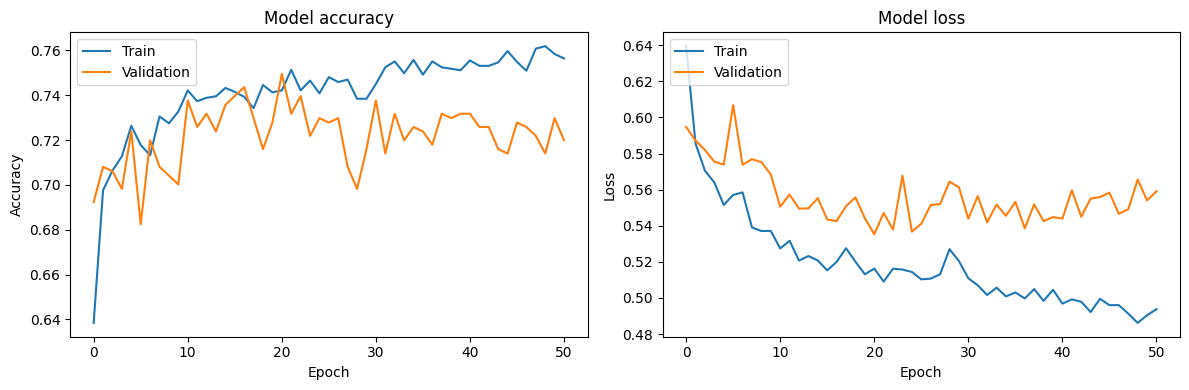

Model saved as ../models/rnn_model_20240507_135530.keras


In [19]:
rnn_model = Sequential()
rnn_model.add(Input(shape=(10,1)))
rnn_model.add(SimpleRNN(128, return_sequences=True)) 
rnn_model.add(SimpleRNN(64, return_sequences=True))  
rnn_model.add(SimpleRNN(64, return_sequences=True))  
rnn_model.add(SimpleRNN(32, return_sequences=True)) 
rnn_model.add(SimpleRNN(32, return_sequences=True)) 
rnn_model.add(SimpleRNN(16))  
rnn_model.add(Dense(16, activation='relu'))  
rnn_model.add(Dense(1, activation='sigmoid'))

rnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
early_stopping = EarlyStopping(monitor='val_accuracy', patience=30)
rnn_history = rnn_model.fit(X_train, y_train, epochs=100, batch_size=256, callbacks=[early_stopping], validation_split=0.1)
plot_history(rnn_history)
save_nn(rnn_model)

In [20]:
y_pred = rnn_model.predict(X_test)
y_pred = (y_pred > 0.5)

rnn_f1 = f1_score(y_test, y_pred, average='binary')
rnn_accuracy = accuracy_score(y_test, y_pred)
rnn_recall = recall_score(y_test, y_pred, average='binary')
rnn_conf_matrix = confusion_matrix(y_test, y_pred)

print(f'F1 Score: {rnn_f1}')
print(f'Accuracy: {rnn_accuracy}')
print(f'Recall: {rnn_recall}')
print(f'Confusion Matrix:\n {rnn_conf_matrix}')

40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
F1 Score: 0.7199354317998385
Accuracy: 0.7263406940063092
Recall: 0.6686656671664168
Confusion Matrix:
 [[475 126]
 [221 446]]


Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 174ms/step - accuracy: 0.4809 - loss: 1.0421 - val_accuracy: 0.4892 - val_loss: 0.9211
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.4931 - loss: 0.9067 - val_accuracy: 0.4892 - val_loss: 0.7573
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.4763 - loss: 0.7338 - val_accuracy: 0.5108 - val_loss: 0.7166
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.5093 - loss: 0.7298 - val_accuracy: 0.5108 - val_loss: 0.7537
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.5054 - loss: 0.7459 - val_accuracy: 0.5108 - val_loss: 0.6937
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.5429 - loss: 0.6894 - val_accuracy: 0.5710 - val_loss: 0.6820
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.5462 - loss: 0.6872 - val_accuracy: 0.5394 - val_loss: 0.6921
Epoch 8/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.5371 - loss: 0.6902 - val_accuracy: 0.6124 - val_loss

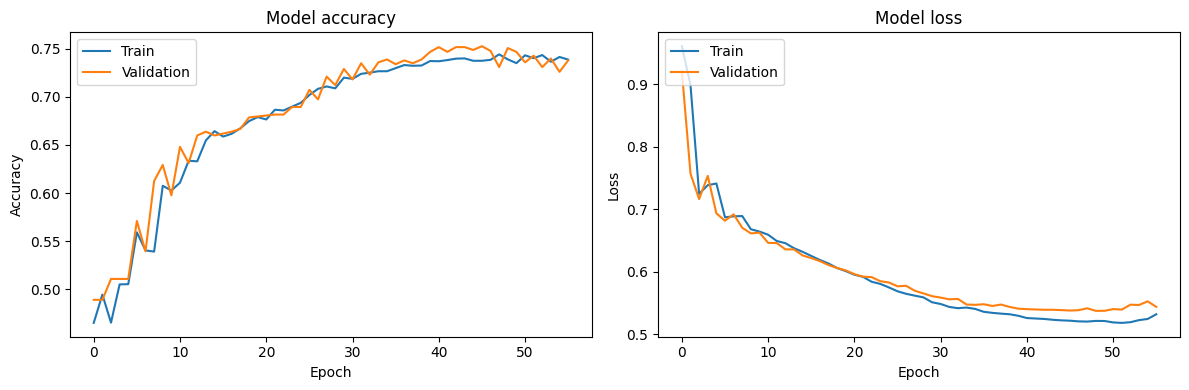

Model saved as ../models/cnn_model_20240507_135537.keras


In [21]:
cnn_model = Sequential()
cnn_model.add(Input(shape=(10,1)))
cnn_model.add(Conv1D(32, 2, activation='relu', padding='same'))
cnn_model.add(MaxPooling1D(pool_size=2))
cnn_model.add(Conv1D(64, 2, activation='relu', padding='same'))
cnn_model.add(MaxPooling1D(pool_size=2))
cnn_model.add(Conv1D(128, 2, activation='relu', padding='same'))
cnn_model.add(Flatten())
cnn_model.add(Dense(256, activation='relu'))
cnn_model.add(Dense(1, activation='sigmoid'))

cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
early_stopping = EarlyStopping(monitor='val_accuracy', patience=10)
cnn_history = cnn_model.fit(X_train, y_train, epochs=100, batch_size=2048, validation_split=0.2, callbacks=[early_stopping])
plot_history(cnn_history)
save_nn(cnn_model)

In [22]:
y_pred = cnn_model.predict(X_test)
y_pred = (y_pred > 0.5)

cnn_f1 = f1_score(y_test, y_pred, average='binary')
cnn_accuracy = accuracy_score(y_test, y_pred)
cnn_recall = recall_score(y_test, y_pred, average='binary')
cnn_conf_matrix = confusion_matrix(y_test, y_pred)

print(f'F1 Score: {cnn_f1}')
print(f'Accuracy: {cnn_accuracy}')
print(f'Recall: {ann_recall}')
print(f'Confusion Matrix:\n {cnn_conf_matrix}')

40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
F1 Score: 0.7483095416979715
Accuracy: 0.7358044164037855
Recall: 0.568215892053973
Confusion Matrix:
 [[435 166]
 [169 498]]


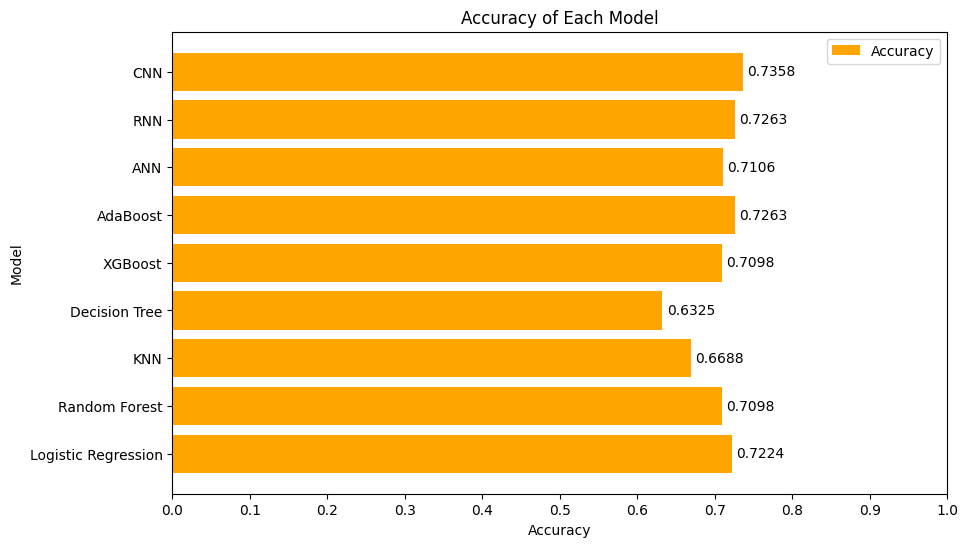

In [23]:
accuracies = [log_reg_accuracy, rf_accuracy, knn_accuracy, dt_accuracy, xgb_accuracy, ada_accuracy, ann_accuracy, rnn_accuracy, cnn_accuracy]
models = ['Logistic Regression', 'Random Forest', 'KNN', 'Decision Tree', 'XGBoost', 'AdaBoost', 'ANN', 'RNN', 'CNN']

plot_accuracy(accuracies, models)